# Prepare data

Edit and save images with Clahe

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image

# Directories
DATASET_DIR = r"C:\Users\majas\A COVID PROJEKT\COVID-19_Radiography_Dataset"
BASE_SAVE_DIR = r"C:\Users\majas\Desktop\masken 2\bearbeitete_xrays"  # Main folder for processed data
os.makedirs(BASE_SAVE_DIR, exist_ok=True)

# Function to enhance contrast using CLAHE (for images only, not masks)
def enhance_contrast(image):
    image_np = np.array(image)  # PIL -> NumPy
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(image_np)  # Apply CLAHE
    return Image.fromarray(enhanced)  # Convert back from NumPy to PIL

#  utomatically collect image & mask paths
def collect_image_and_mask_paths(dataset_dir):
    image_paths, mask_paths, classes = [], [], []
    
    for cls in ["COVID", "Normal", "Lung_Opacity", "Viral Pneumonia"]:
        class_dir = os.path.join(dataset_dir, cls)
        images_dir = os.path.join(class_dir, "images")
        masks_dir = os.path.join(class_dir, "masks")

        if not os.path.exists(images_dir) or not os.path.exists(masks_dir):
            print(f"⚠ WARNING: Missing folders for class '{cls}', skipping...")
            continue

        img_files = sorted([os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith((".png", ".jpg", ".jpeg"))])
        mask_files = sorted([os.path.join(masks_dir, f) for f in os.listdir(masks_dir) if f.endswith((".png", ".jpg", ".jpeg"))])

        if len(img_files) != len(mask_files):
            print(f"⚠ WARNING: {cls} has {len(img_files)} images but {len(mask_files)} masks!")

        image_paths.extend(img_files)
        mask_paths.extend(mask_files)
        classes.extend([cls] * len(img_files))  

    return image_paths, mask_paths, classes

#Collect image and mask paths
image_paths, mask_paths, class_labels = collect_image_and_mask_paths(DATASET_DIR)

if len(image_paths) == 0 or len(mask_paths) == 0:
    raise ValueError("ERROR: No images or masks found! Check your dataset folder.")

# Process and save images with CLAHE, masks remain unchanged
def process_and_save_images(image_paths, mask_paths, class_labels, base_save_dir):
    for img_path, mask_path, cls in zip(image_paths, mask_paths, class_labels):
        # Create subfolders per class
        class_dir = os.path.join(base_save_dir, cls)
        images_dir = os.path.join(class_dir, "images")
        masks_dir = os.path.join(class_dir, "masks")
        
        os.makedirs(images_dir, exist_ok=True)
        os.makedirs(masks_dir, exist_ok=True)

        # Extract filenames
        img_name = os.path.basename(img_path)
        mask_name = os.path.basename(mask_path)

        # Load and enhance image using CLAHE
        img = Image.open(img_path).convert("L")
        img = enhance_contrast(img)  # Apply CLAHE only to the image
        img = img.resize((256, 256))  # Resize image

        # Load mask (unchanged)
        mask = Image.open(mask_path).convert("L")
        mask = mask.resize((256, 256))

        # Save in the desired structure
        img.save(os.path.join(images_dir, img_name))  # Save processed image
        mask.save(os.path.join(masks_dir, mask_name))  # Save unchanged mask

# Start processing & saving
process_and_save_images(image_paths, mask_paths, class_labels, BASE_SAVE_DIR)

print(f" All processed images saved in {BASE_SAVE_DIR} (masks remain unchanged)")


read and split data

In [ ]:
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Base directory for processed data
BASE_PROCESSED_DIR = r"C:\Users\majas\Desktop\masken 2\bearbeitete_xrays"

# Function: Collect images & masks
def collect_processed_images_and_masks(base_dir):
    image_paths, mask_paths = [], []
    
    for cls in ["COVID", "Normal", "Lung_Opacity", "Viral Pneumonia"]:
        images_dir = os.path.join(base_dir, cls, "images")
        masks_dir = os.path.join(base_dir, cls, "masks")

        if not os.path.exists(images_dir) or not os.path.exists(masks_dir):
            print(f" WARNING: Missing folder for class '{cls}', skipping...")
            continue

        img_files = sorted([os.path.join(images_dir, f) for f in os.listdir(images_dir) if f.endswith((".png", ".jpg", ".jpeg"))])
        mask_files = sorted([os.path.join(masks_dir, f) for f in os.listdir(masks_dir) if f.endswith((".png", ".jpg", ".jpeg"))])

        if len(img_files) != len(mask_files):
            print(f" WARNING: Class '{cls}' has {len(img_files)} images, but {len(mask_files)} masks!")

        image_paths.extend(img_files)
        mask_paths.extend(mask_files)

    return image_paths, mask_paths

# Collect images & masks
image_paths, mask_paths = collect_processed_images_and_masks(BASE_PROCESSED_DIR)

if len(image_paths) == 0 or len(mask_paths) == 0:
    raise ValueError(" ERROR: No processed images or masks found! Please check the dataset folder.")

print(f" Total images: {len(image_paths)}, Total masks: {len(mask_paths)}")

# Split into Train (70%), Validation (20%), Test (10%)
train_images, temp_images, train_masks, temp_masks = train_test_split(image_paths, mask_paths, test_size=0.3, random_state=42)
valid_images, test_images, valid_masks, test_masks = train_test_split(temp_images, temp_masks, test_size=0.33, random_state=42)

print(f"Training: {len(train_images)} images")
print(f"Validation: {len(valid_images)} images")
print(f"Test: {len(test_images)} images")

# Efficient image & mask loading using `tf.data`
def load_image_and_mask(image_path, mask_path):
    # Load image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)  
    image = tf.image.resize(image, [256, 256]) / 255.0  

    # Load mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)  
    mask = tf.image.resize(mask, [256, 256]) / 255.0  

    return image, mask

# Create `tf.data` dataset
def create_tf_dataset(image_paths, mask_paths, batch_size=8, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000)

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Create train, validation & test datasets
train_dataset = create_tf_dataset(train_images, train_masks, batch_size=4, shuffle=True)
valid_dataset = create_tf_dataset(valid_images, valid_masks, batch_size=4, shuffle=False)
test_dataset = create_tf_dataset(test_images, test_masks, batch_size=4, shuffle=False)

print(" Datasets created successfully!")


📊 Gesamtbilder: 21165, Gesamtmasken: 21165
✅ Training: 14815 Bilder
✅ Validation: 4254 Bilder
✅ Test: 2096 Bilder
✅ Datensätze erfolgreich erstellt!


Model 3 U-Net model with Dilated Residuals & ASPP with adam as optimzer

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, UpSampling2D, 
                                     Concatenate, BatchNormalization, Activation, 
                                     Dropout, Add, LeakyReLU, GlobalAveragePooling2D, 
                                     Dense, Multiply, AveragePooling2D)
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam

#  Dice Coefficient as a metric
def dice_coefficient(y_true, y_pred):
    numerator = 2 * K.sum(y_true * y_pred) + 1e-6
    denominator = K.sum(y_true + y_pred) + 1e-6
    return numerator / denominator

#  IoU (Intersection over Union) as a metric
def iou_metric(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + 1e-6) / (union + 1e-6)

#  Dice Loss for better segmentation
def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

#  Combined Loss: Dice Loss + Binary Crossentropy
def combined_loss(y_true, y_pred):
    return 0.5 * dice_loss(y_true, y_pred) + 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred)

#  Dilated Residual Block (with dilated convolutions for better context and 1x1 shortcut)
def dilated_residual_block(x, num_filters, dilation_rate=2):
    res = x  # Shortcut connection

    # First convolution
    x = Conv2D(num_filters, (3,3), padding="same", dilation_rate=dilation_rate)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = Dropout(0.3)(x)

    # Second convolution
    x = Conv2D(num_filters, (3,3), padding="same", dilation_rate=dilation_rate)(x)
    x = BatchNormalization()(x)

    # Adjust shortcut if channel dimensions don't match
    if res.shape[-1] != x.shape[-1]:
        res = Conv2D(num_filters, (1,1), padding="same")(res)
        res = BatchNormalization()(res)

    # Add shortcut connection
    x = Add()([x, res])
    x = LeakyReLU(alpha=0.1)(x)
    return x

#  SE-Block (Squeeze-and-Excitation for channel attention)
def se_block(x, ratio=16):
    channels = x.shape[-1]
    se = GlobalAveragePooling2D()(x)
    se = Dense(channels // ratio, activation="relu")(se)
    se = Dense(channels, activation="sigmoid")(se)
    x = Multiply()([x, se])
    return x

#  ASPP Block for multi-scale feature fusion
def aspp_block(x):
    shape = x.shape[1:-1]  # Extract height/width

    x1 = Conv2D(256, (1,1), padding="same", activation="relu")(x)
    x2 = Conv2D(256, (3,3), padding="same", dilation_rate=6,  activation="relu")(x)
    x3 = Conv2D(256, (3,3), padding="same", dilation_rate=12, activation="relu")(x)
    x4 = Conv2D(256, (3,3), padding="same", dilation_rate=18, activation="relu")(x)

    x5 = AveragePooling2D(pool_size=shape)(x)
    x5 = Conv2D(256, (1,1), padding="same", activation="relu")(x5)
    x5 = UpSampling2D(size=shape)(x5)

    return Concatenate()([x1, x2, x3, x4, x5])

#  U-Net model with ASPP + Dilated Residual Blocks
def build_unet(input_shape=(256, 256, 1)):
    num_filters = [32, 64, 128, 256, 512, 1024]
    inputs = Input(input_shape)

    skip_x = []
    x = inputs

    # Encoder
    for f in num_filters:
        x = dilated_residual_block(x, f)
        x = se_block(x)
        skip_x.append(x)
        x = MaxPooling2D((2,2))(x)

    # Bridge with ASPP
    x = aspp_block(x)

    # Decoder
    num_filters.reverse()
    skip_x.reverse()

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2,2))(x)
        x = Concatenate()([x, skip_x[i]])
        x = dilated_residual_block(x, f)

    # Output
    outputs = Conv2D(1, (1,1), padding="same", activation="sigmoid")(x)

    model = Model(inputs, outputs)
    return model

#  Compile model with advanced metrics
unet_model = build_unet()
optimizer = Adam(learning_rate=1e-4)

unet_model.compile(
    optimizer=optimizer, 
    loss=combined_loss, 
    metrics=["accuracy", dice_coefficient, iou_metric]  # Additional metrics
)

unet_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [2]:
for i, layer in enumerate(unet_model.layers):
    print(i, layer.name, layer.output_shape)


0 input_1 [(None, 256, 256, 1)]
1 conv2d (None, 256, 256, 32)
2 batch_normalization (None, 256, 256, 32)
3 leaky_re_lu (None, 256, 256, 32)
4 dropout (None, 256, 256, 32)
5 conv2d_1 (None, 256, 256, 32)
6 conv2d_2 (None, 256, 256, 32)
7 batch_normalization_1 (None, 256, 256, 32)
8 batch_normalization_2 (None, 256, 256, 32)
9 add (None, 256, 256, 32)
10 leaky_re_lu_1 (None, 256, 256, 32)
11 global_average_pooling2d (None, 32)
12 dense (None, 2)
13 dense_1 (None, 32)
14 multiply (None, 256, 256, 32)
15 max_pooling2d (None, 128, 128, 32)
16 conv2d_3 (None, 128, 128, 64)
17 batch_normalization_3 (None, 128, 128, 64)
18 leaky_re_lu_2 (None, 128, 128, 64)
19 dropout_1 (None, 128, 128, 64)
20 conv2d_4 (None, 128, 128, 64)
21 conv2d_5 (None, 128, 128, 64)
22 batch_normalization_4 (None, 128, 128, 64)
23 batch_normalization_5 (None, 128, 128, 64)
24 add_1 (None, 128, 128, 64)
25 leaky_re_lu_3 (None, 128, 128, 64)
26 global_average_pooling2d_1 (None, 64)
27 dense_2 (None, 4)
28 dense_3 (None, 64

Train Modell 3

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import os

# 📌 Model save path
MODEL_SAVE_PATH = r"C:\Users\majas\Desktop\masken 2\entwickeltes_masken_model.h5"

#  Check if GPU is available
print("Available GPUs:", tf.config.list_physical_devices('GPU'))

if tf.config.list_physical_devices('GPU'):
    print(" TensorFlow will use the GPU!")
else:
    print(" WARNING: No GPU found, TensorFlow is running on the CPU!")

#  Callbacks for model training
checkpoint = ModelCheckpoint(
    MODEL_SAVE_PATH,   # Save the best model here
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=2,
    verbose=1
)

#  Optimize the data pipeline for more efficient training
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset = valid_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

#  Train using `tf.data.Dataset` (memory-efficient)
history = unet_model.fit(
    train_dataset,                  # Training dataset (loaded with tf.data)
    validation_data=valid_dataset, # Validation dataset (tf.data)
    epochs=20,                      # Number of epochs
    verbose=1,                      # Progress bar per epoch
    callbacks=[checkpoint, early_stop, reduce_lr]  # Save only the best model
)

print(f" Training completed! Best model saved at: {MODEL_SAVE_PATH}")


Verfügbare GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ TensorFlow wird die GPU verwenden!
Epoch 1/20
3704/3704 [==============================] - ETA: 0s - loss: 0.0285 - accuracy: 0.9892 - dice_coefficient: 0.9715 - iou_metric: 0.9448
Epoch 1: val_loss improved from inf to 0.02473, saving model to C:\Users\majas\Desktop\masken 2\entwickeltes_masken_model.h5
3704/3704 [==============================] - 6213s 2s/step - loss: 0.0285 - accuracy: 0.9892 - dice_coefficient: 0.9715 - iou_metric: 0.9448 - val_loss: 0.0247 - val_accuracy: 0.9905 - val_dice_coefficient: 0.9754 - val_iou_metric: 0.9522 - lr: 1.0000e-04
Epoch 2/20
3704/3704 [==============================] - ETA: 0s - loss: 0.0235 - accuracy: 0.9910 - dice_coefficient: 0.9763 - iou_metric: 0.9538
Epoch 2: val_loss improved from 0.02473 to 0.02217, saving model to C:\Users\majas\Desktop\masken 2\entwickeltes_masken_model.h5
3704/3704 [==============================] - 5672s 2s/step - loss: 0.0235 - a

tests on Model 3

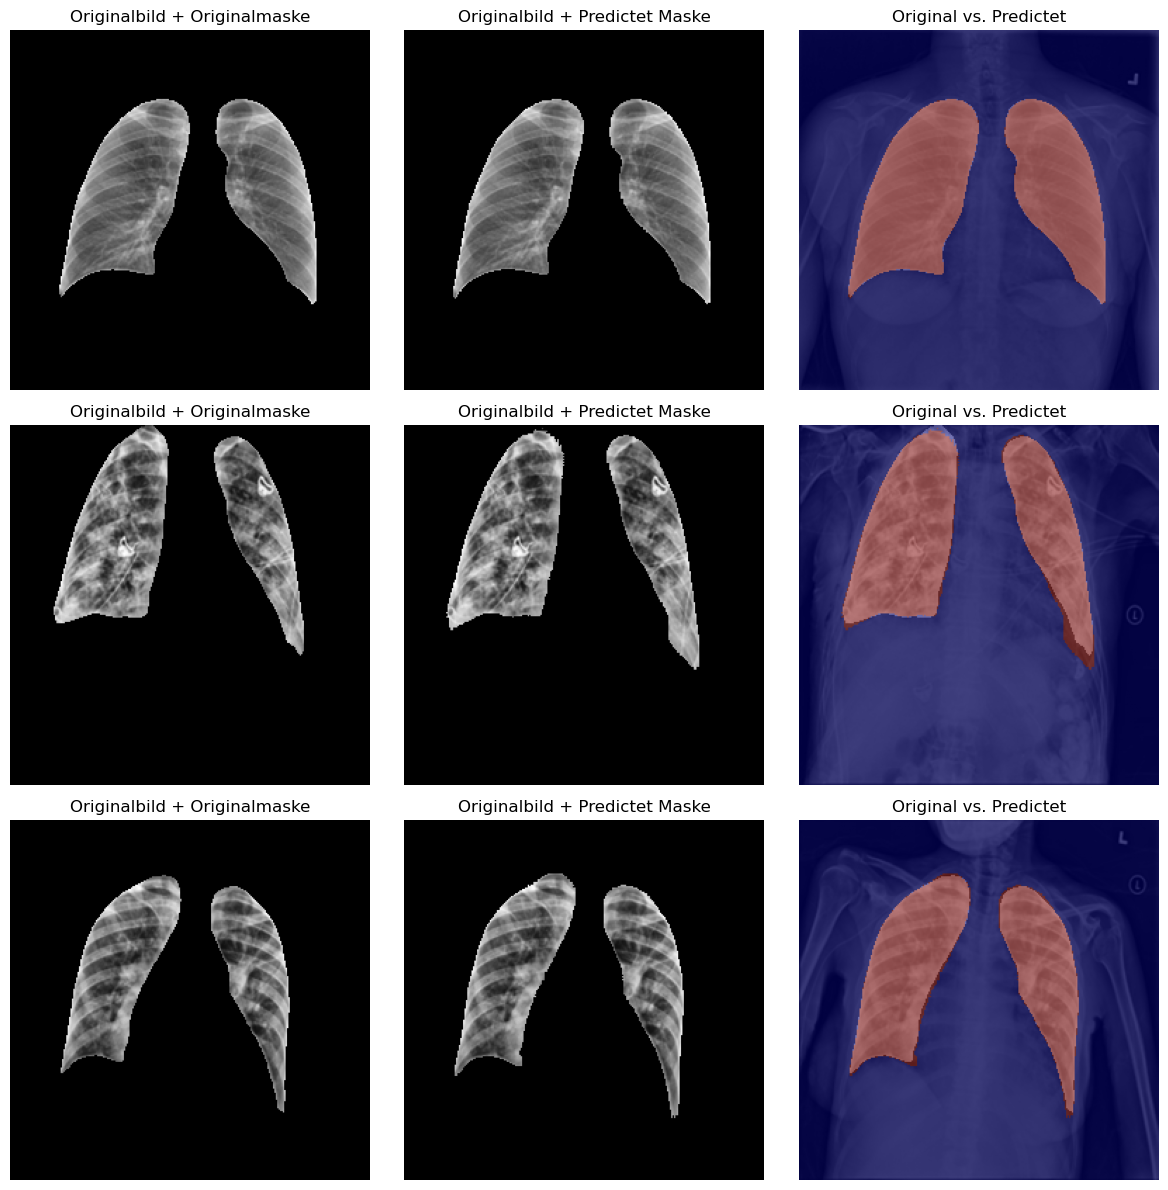

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model

#  Model path
MODEL_PATH = r"C:\Users\majas\Desktop\masken 2\entwickeltes_masken_model.h5"

#  Custom metrics
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return numerator / (denominator + tf.keras.backend.epsilon())

def iou_metric(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true + y_pred - y_true * y_pred)
    return intersection / (union + tf.keras.backend.epsilon())

def combined_loss(y_true, y_pred):
    return 0.5 * (1 - dice_coefficient(y_true, y_pred)) + 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred)

#  Load the model
custom_objects = {"dice_coefficient": dice_coefficient, "iou_metric": iou_metric, "combined_loss": combined_loss}
unet_model = load_model(MODEL_PATH, custom_objects=custom_objects, compile=False)

#  Recompile the model
unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=combined_loss, metrics=["accuracy", dice_coefficient, iou_metric])

#  Function to visualize results
def show_predictions_with_comparison(dataset, num_samples=3):
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4 * num_samples))

    for i, (image_batch, mask_batch) in enumerate(dataset.take(num_samples)):
        image = image_batch[0].numpy().squeeze()  # First image from batch (2D)
        mask = mask_batch[0].numpy().squeeze()    # Ground truth mask (2D)

        # Predict with model
        pred_mask = unet_model.predict(tf.expand_dims(image, axis=0), verbose=0)[0]
        pred_mask = (pred_mask > 0.5).astype(np.uint8).squeeze()  # **Fix: Create 2D mask**

        #  Column 1: Original image with ground truth mask
        masked_image = np.copy(image)  # Copy of the image
        masked_image[mask == 0] = 0  # **Set everything except lung areas to black**
        axes[i, 0].imshow(masked_image, cmap="gray")
        axes[i, 0].set_title("Original Image + Ground Truth Mask")

        #  Column 2: Original image with predicted mask
        pred_masked_image = np.copy(image)  # Copy of the image
        pred_masked_image[pred_mask == 0] = 0  # **Set everything except predicted lung areas to black**
        axes[i, 1].imshow(pred_masked_image, cmap="gray")
        axes[i, 1].set_title("Original Image + Predicted Mask")

        #  Column 3: Comparison of ground truth and predicted mask
        axes[i, 2].imshow(image, cmap="gray")  # Original image in background
        axes[i, 2].imshow(mask, cmap="gray", alpha=0.5, label="Ground Truth Mask")
        axes[i, 2].imshow(pred_mask, cmap="jet", alpha=0.5, label="Predicted Mask")  
        axes[i, 2].set_title("Ground Truth vs. Predicted")

        for ax in axes[i]:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

#  Display results
show_predictions_with_comparison(test_dataset, num_samples=3)


model testing with the bad masks

1/1 [==============================] - 5s 5s/step


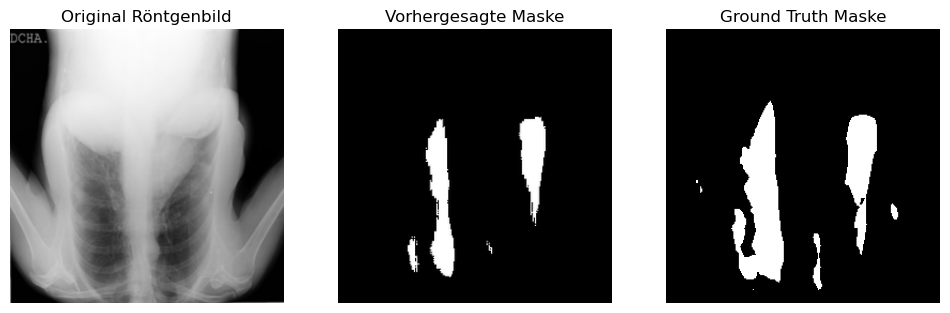

1/1 [==============================] - 0s 30ms/step


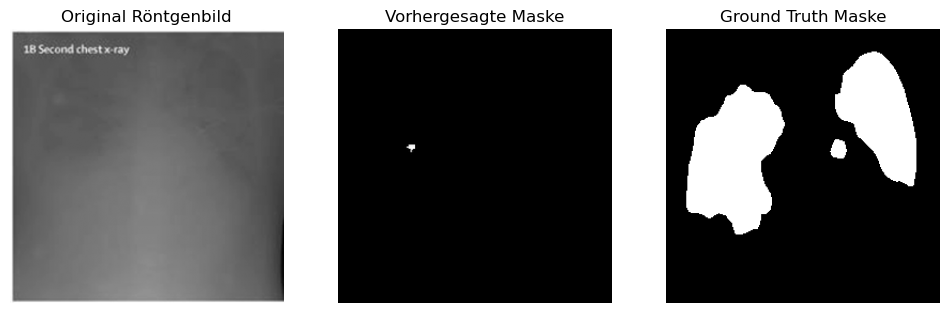

1/1 [==============================] - 0s 30ms/step


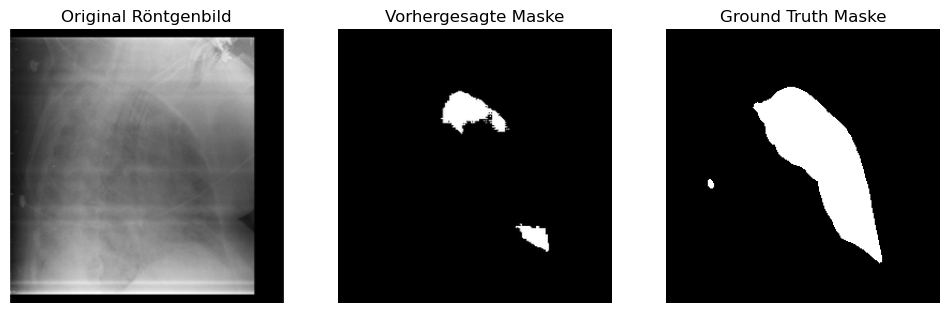

1/1 [==============================] - 0s 47ms/step


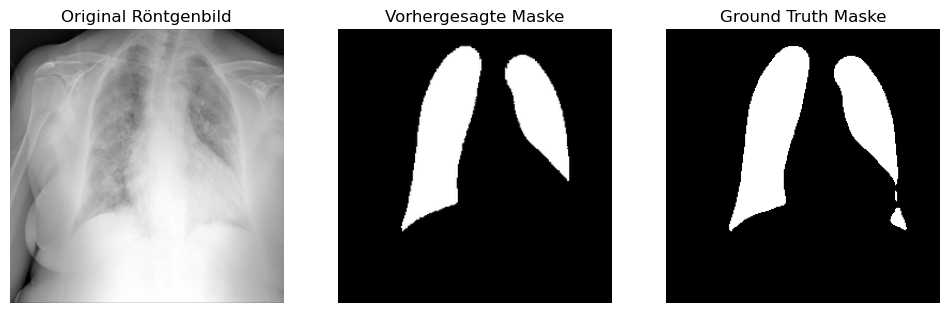

1/1 [==============================] - 0s 30ms/step


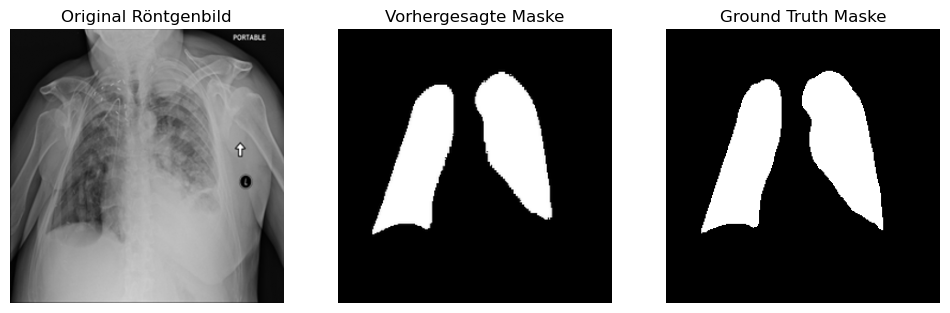

1/1 [==============================] - 0s 33ms/step


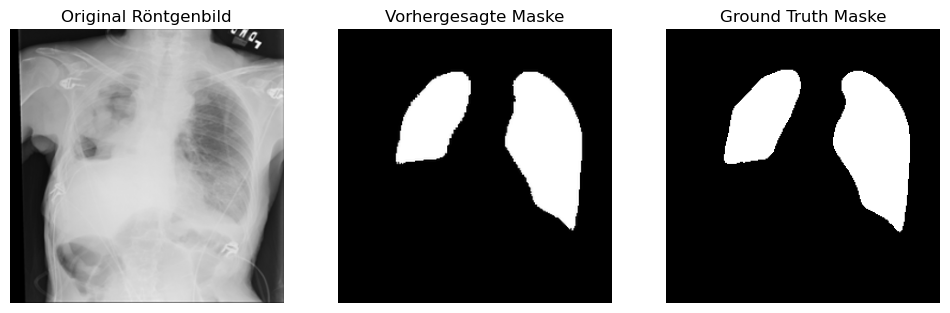

1/1 [==============================] - 0s 30ms/step


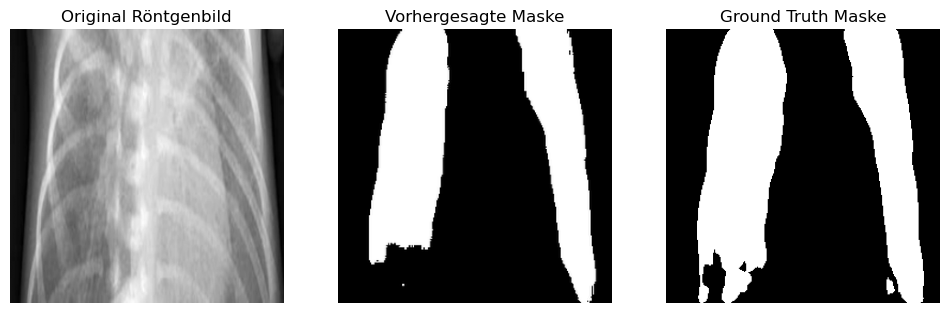

In [ ]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from PIL import Image

#  Define custom functions
def dice_coefficient(y_true, y_pred):
    numerator = 2 * K.sum(y_true * y_pred) + 1e-6
    denominator = K.sum(y_true + y_pred) + 1e-6
    return numerator / denominator

def iou_metric(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + 1e-6) / (union + 1e-6)

def dice_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

def combined_loss(y_true, y_pred):
    return 0.5 * dice_loss(y_true, y_pred) + 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred)

#  Load the trained model
MODEL_PATH = r"C:\Users\majas\Desktop\masken 2\entwickeltes_masken_model.h5"
model = load_model(MODEL_PATH, custom_objects={
    "dice_coefficient": dice_coefficient,
    "iou_metric": iou_metric,
    "combined_loss": combined_loss
})

#  Dataset path
DATASET_PATH = r"C:\Users\majas\Downloads\COVID-19_Radiography_Dataset"

#  Define test images
test_images = {
    "COVID": [257, 698, 1799, 2267],
    "Lung_Opacity": [1085, 1278],
    "Viral Pneumonia": [203]
}
#  Normalize images (same preprocessing as in training)
def preprocess_image(image_path, target_size=(256, 256)):
    img = load_img(image_path, color_mode="grayscale", target_size=target_size)
    img_array = img_to_array(img) / 255.0  # Normalize to [0,1]
    return np.expand_dims(img_array, axis=0)  # Add batch dimension

#  Show model predictions
def plot_predictions(image_path, mask_path, predicted_mask):
    original_image = load_img(image_path, color_mode="grayscale")
    original_mask = load_img(mask_path, color_mode="grayscale")  # 🔥 Load ground truth mask

    #  Make predicted mask binary (black = 0, white = 255)
    predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8) * 255

    #  Resize to match original size
    predicted_mask_resized = Image.fromarray(predicted_mask_binary).resize(original_image.size, Image.LANCZOS)

    #  Plot the result
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    ax[0].imshow(original_image, cmap="gray")
    ax[0].set_title("Original X-ray Image")

    ax[1].imshow(predicted_mask_resized, cmap="gray")  # 🔥 Predicted mask
    ax[1].set_title("Predicted Mask")

    ax[2].imshow(original_mask, cmap="gray")  # 🔥 Show ground truth mask
    ax[2].set_title("Ground Truth Mask")

    for a in ax:
        a.axis("off")

    plt.show()

#  Loop over all test images and run the prediction function
for category, indices in test_images.items():
    for index in indices:
        image_path = os.path.join(DATASET_PATH, category, "images", f"{category}-{index}.png")
        mask_path = os.path.join(DATASET_PATH, category, "masks", f"{category}-{index}.png")

        # Check if files exist
        if os.path.exists(image_path) and os.path.exists(mask_path):
            img_array = preprocess_image(image_path)
            predicted_mask = model.predict(img_array)[0, :, :, 0]  # Remove batch dimension

            # Call the plotting function
            plot_predictions(image_path, mask_path, predicted_mask)
        else:
            print(f"⚠ WARNING: File not found - {image_path} or {mask_path}")
